In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## for distances
from scipy.spatial.distance import cosine

In [ ]:
# Set pandas formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [ ]:
# Set up wikidata API
!pip -q install qwikidata
!pip -q install sparqlwrapper

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
import seaborn as sns
import folium # mapping
from folium.plugins import HeatMap
import missingno as msno
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from typing import List, Dict

import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00
Setup Complete


In [ ]:
# modified from https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
import json
import ast

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            print(result)
            break
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    # Function to remove invalid control characters
    def __remove_invalid_chars(text):
        return ''.join(char for char in text if ord(char) > 31 or char == '\n' or char == '\t')

    def _load(self) -> List[Dict]:
        """
        Helper function that loads the data from Wikidata using the SPARQLWrapper library, and transforms the results into
        a list of dictionaries.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        results = self.sparql.queryAndConvert()['results']['bindings']
        # Preprocess the JSON response to remove control characters
        results = json.dumps(results).encode('utf-8').decode('unicode_escape')

        return results

    def load_as_dataframe(self) -> pd.DataFrame:
        """
        Executes the SPARQL query and returns the results as a Pandas DataFrame.
        :return: A Pandas DataFrame representing the query results.
        """
        results = self._load()
        df = pd.read_json(results)
        df = df.applymap(lambda x: x['value'])
        return df

# Q1



## (a)

In [ ]:
# Q1a - Query Wikidata to build a single table, listing each country in distinct
#       rows. This table should include columns for the most up-to-date figures
#       of life expectancy, median income,Human Development Index (HDI),
#       retirement age, and unemployment rate. Note that for multi-year data
#       like HDI, SPARQL queries (e.g., ”?country wdt:P1081 ?HDI”) automatically
#       provide the latest HDI values. Ensure your query includes all entities
#       defined as ”Instance of a country” and that each country has
#       corresponding data for all the required columns. Display this table.


# Some relations such as wdt:P1081 links to multiple values,
# Fortunately, calling ?country wdt:P1081 ?HDI will automatically return the latest HDI,

countryQuery = """
SELECT
  ?countryLabel
  ?lifeExpectancy
  ?medianIncome
  ?HDI
  ?retirementAge
  ?unemploymentRate
WHERE {
  ## YOUR CODE STARTS HERE
    ?country wdt:P31 wd:Q6256; # finding any term that is an instance of object
                               # country
             wdt:P2250 ?lifeExpectancy; # Finding any country instance that is
                                       # related to a number object through a
                                       # life-expectancy relational tag (predicant)

             wdt:P3529 ?medianIncome;
             wdt:P1081 ?HDI;
             wdt:P3001 ?retirementAge;
             wdt:P1198 ?unemploymentRate.

  # code should give me most up-to-date figures (NO filters)

  # provides all entity labels in english
  SERVICE wikibase:label {bd:serviceParam wikibase:language "en".}
  ### YOUR CODE ENDS HERE
}
"""

## Output format is given below
Country_df = WikiDataQueryResults(countryQuery).load_as_dataframe()
Country_df

,medianIncome,retirementAge,unemploymentRate,lifeExpectancy,HDI,countryLabel
0,70336,65,7,83.62,0.936,Canada
1,34822,60,4,83.98488,0.925,Japan
2,557655,60,4,83.98488,0.925,Japan
3,51489,67,3,82.50976,0.838,Norway
4,51489,67,3,82.50976,0.845,Norway
...,...,...,...,...,...,...
61,65000,67,6,82.5,0.951,Australia
62,35562,65,6,81.61244,0.937,New Zealand
63,24980,60,11,74.561,0.875,Saudi Arabia
64,328224,60,0.9,77.41,0.8,Thailand


## (b)

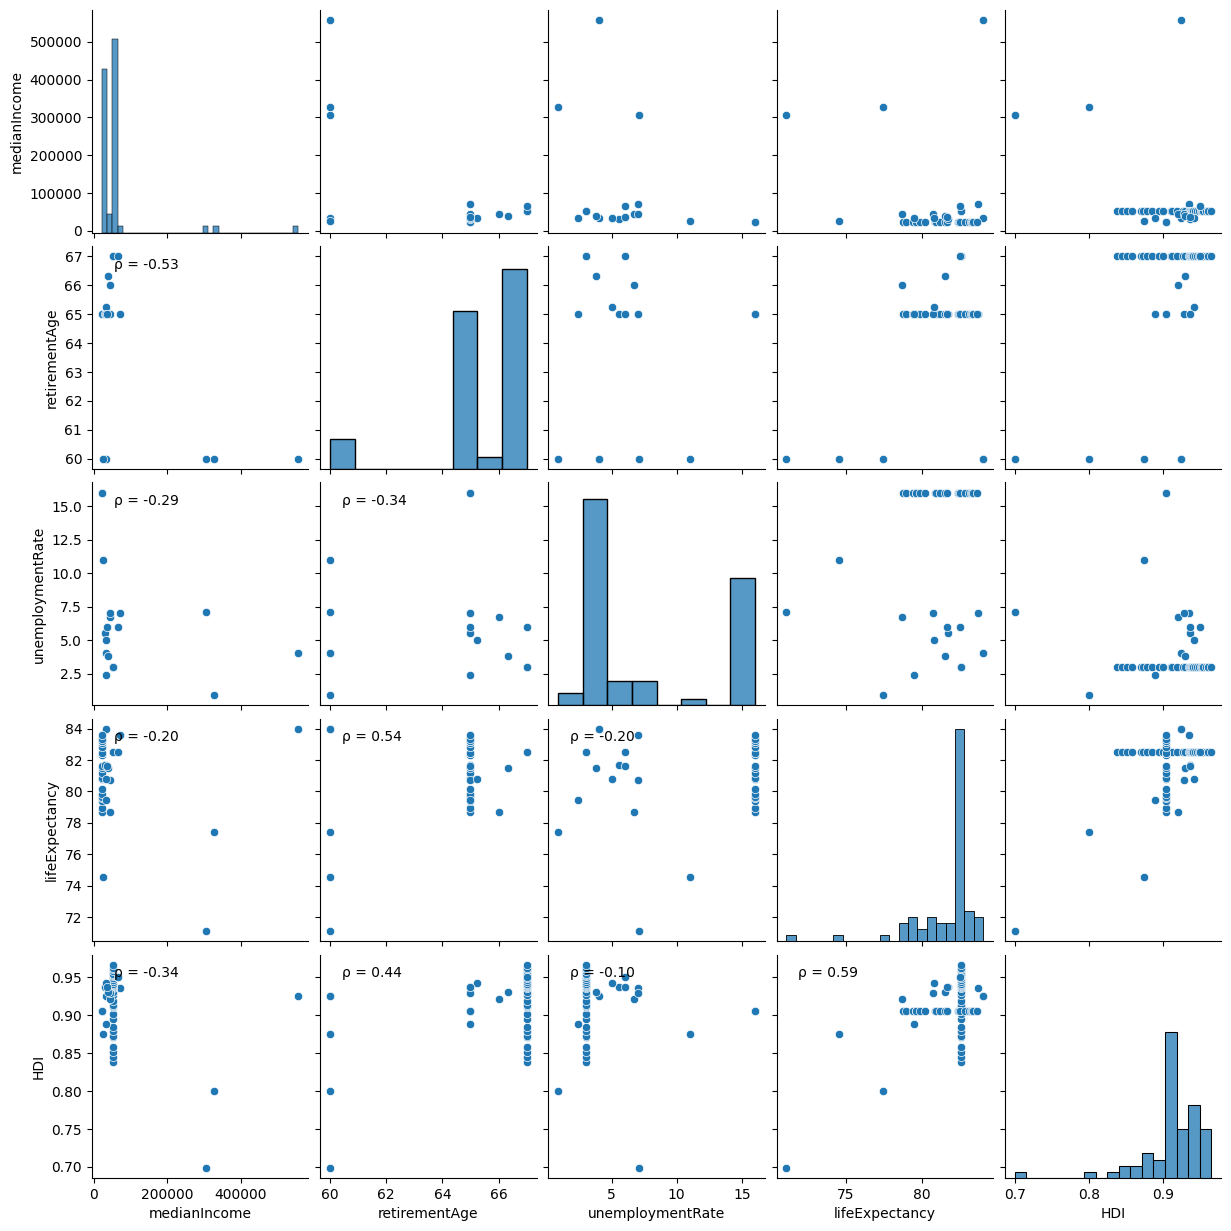

In [ ]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

# get everything to numerical
Country_df=Country_df.drop(columns=['countryLabel'])
Country_df = Country_df.apply(pd.to_numeric)

# pairplot
## YOUR CODE STARTS HERE

g= sns.pairplot(data = Country_df)# seaborn's pair plot function
## YOUR CODE ENDS HERE

g.map_lower(corrfunc)
plt.show()

## (c)

**Enter answer here:**
The two country properties that are most correlated are Life Expectancy and HDI. The high correlation is understandable since HDI is a summary statistic of human development which includes life expectancy.

# Q2

## (a)

In [ ]:
# Q2a - Query Wikidata to create a table including movies, actors, and genres.
#       Focus on actors who have specifically won the Oscar for Best Actress
#       (but not Best Actor, which is a separate Oscar in WikiData) and movies
#       released between 1995 and 2023 (excluding both years). Limit the
#       query to 2000 records and display the resulting DataFrame.


actor_genre_Query = """
SELECT distinct ?movieLabel ?actorLabel ?genreLabel
WHERE {
  ## YOUR CODE STARTS HERE

  ?movie wdt:P31 wd:Q11424;  # Instance of a movie
         wdt:P161 ?actor;    # Actors
         wdt:P136 ?genre;    # Genre
         wdt:P577 ?releaseDate. # Release Date

         ?actor wdt:P166 wd:Q103618. # getting all actors who won award (P166)
                                     #[relational] as a best actress award
                                     # (Q103618) [object]

  FILTER(YEAR(?releaseDate) < 2023)
  FILTER(YEAR(?releaseDate) > 1995)

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
limit 2000

  ## YOUR CODE ENDS HERE
"""

## Output format is given below
actor_genre_df = WikiDataQueryResults(actor_genre_Query).load_as_dataframe()
actor_genre_df

,movieLabel,actorLabel,genreLabel
0,The Dark Knight Rises,Marion Cotillard,drama film
1,Midnight in Paris,Marion Cotillard,fantasy film
2,The Dark Knight Rises,Marion Cotillard,superhero film
3,Midnight in Paris,Marion Cotillard,romantic comedy
4,Innocence,Marion Cotillard,film based on literature
...,...,...,...
1995,Duplicity,Julia Roberts,thriller film
1996,Catwoman,Frances McDormand,thriller film
1997,Catwoman,Frances McDormand,action film
1998,Runaway Bride,Julia Roberts,drama film


## (b)

genreLabel,American football film,Christmas film,LGBT-related film,Lesbian-related film,Satanic film,Western film,action comedy film,action film,action thriller,adventure film,alien invasion,alternate history,alternate history film,apocalyptic film,art film,arthouse science fiction film,biographical film,biopunk,black comedy,black comedy film,blaxploitation film,boxing film,buddy cop film,buddy film,children's film,cinematic fairy tale,comedy,comedy drama,comedy film,comedy horror,comedy of manners,comedy of remarriage,comedy thriller,coming-of-age fiction,concert film,costume drama,crime film,crime thriller,crossover fiction,cyberpunk,dark fantasy,detective fiction,detective film,dieselpunk,disaster film,docudrama,documentary film,drama fiction,drama film,dystopian film,epic film,erotic film,erotic thriller,family film,fantasy film,female buddy film,film based on a novel,film based on books,film based on literature,film noir,flashback film,gangster film,ghost film,girls with guns,gothic film,heist film,high fantasy,historical drama,historical film,hood film,horror film,independent film,magic realist film,martial arts film,medieval film,melodrama,mockumentary,musical comedy,musical film,mystery film,mystery play,neo-noir,parody film,pirate film,political drama,political film,political thriller film,post-apocalyptic film,prison film,psychological horror,psychological thriller,psychological thriller film,rape and revenge film,retro-futurism,road movie,romance film,romance novel,romantic comedy,satire,science fiction action film,science fiction comedy,science fiction film,screwball comedy film,sex comedy,slasher film,slice of life,space opera,speculative/fantastic fiction,speculative/fantastic fiction film,sport film,spy film,superhero film,supernatural fiction,supernatural film,surf film,survival film,suspense film,swashbuckler film,teen film,thriller,thriller film,time-travel film,tragicomedy,transgender film,treasure hunt film,trial film,vigilante film,war film,werewolf film
actorLabel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anna Magnani,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Barbra Streisand,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bette Davis,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Brie Larson,0,0,1,0,0,0,1,5,0,2,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,0,3,9,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,0,0,0,1,0,0,0,0,0,0,1,1,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
Cate Blanchett,0,1,4,1,0,1,0,14,0,8,0,0,0,1,0,0,7,0,1,0,0,0,0,2,0,1,0,3,7,1,0,0,0,0,0,1,7,0,0,0,0,0,0,0,1,0,2,1,40,0,1,0,0,1,12,1,14,0,6,1,0,0,1,1,0,2,1,1,0,0,1,0,1,0,1,2,0,0,3,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,10,0,4,1,0,0,2,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,5,0,0,0,3,0,0,4,0
Charlize Theron,0,1,2,0,0,1,1,11,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,16,1,0,0,0,0,5,0,5,1,0,0,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,2,0,3,0,0,0,3,1,0,0,0,0,0,2,0,2,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0
Cher,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,

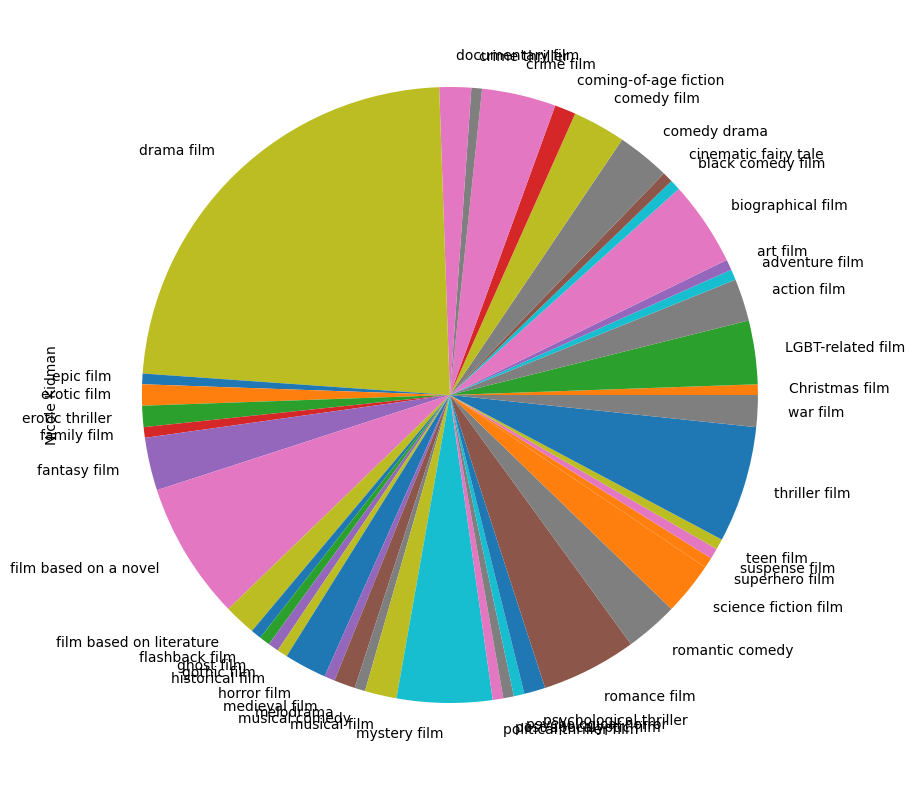

In [ ]:
## YOUR CODE STARTS HERE

# Q2b - From this data, create an actor-genre matrix in a DataFrame, where each
#       row represents an actor and each column a genre. The cells should
#       indicate the count of movies each actor has acted in for each genre.
#       Sort the DataFrame by both indices and columns in ascending order.
#       As demonstrated in the lab, create a pie chart to display the normalized
#       distribution of genres for movies featuring “Nicole Kidman”.

Actor_genre_matrix = pd.pivot_table(actor_genre_df, index = 'actorLabel',
                                    columns = 'genreLabel', aggfunc = 'size',
                                    fill_value = 0)

# actor label column is sorted and the columns are also sorted
Actor_genre_matrix.sort_values(by = ['actorLabel'], ascending = True)

# getting dataframe where only Nicole Kidman is included
Nicole_Kidman_df = Actor_genre_matrix.loc['Nicole Kidman']

# getting movie genre counts
genre_counts = Nicole_Kidman_df
# normalizing each count
Nicole_Kidman_genre_vector = genre_counts/genre_counts.sum()
# plotting normalized vector into a pie chart
Nicole_Kidman_genre_vector.plot(kind = 'pie', figsize = (15,10))
Actor_genre_matrix





## (c)

In [ ]:
# Q2c - Consider each actor’s row in the matrix as a vector representation.
#       Compute the similarity between actors based on the cosine similarity
#       score of these vectors. Identify and display the 3 top 15 similar actor
#       pairs in a DataFrame with columns ‘Actor1’, ‘Actor2’, ‘Cosine Similarity’.
#       Sort this DataFrame in descending order primarily by ‘Cosine Similarity’,
#       and then by ‘Actor1’ and ‘Actor2’.

# Output should be a dataframe with columns "Actor1", "Actor2", "Cosine Similarity",
# Print Top 15, sorted by "Cosine Similarity", then "Actor1", then "Actor2" all in Descending Order

# Initialize an empty list to store the results
similarity_results = []
# hint, similarity_results = [ (actors1, actors2, cosine_similarity_score), ... ]

## YOUR CODE STARTS HERE

# calculates similarity scores between actors
from sklearn.metrics.pairwise import cosine_similarity

# creates a matrix of actor similarity values
Actor_similarity = cosine_similarity(Actor_genre_matrix)

# appending an upper triangular matrix of actor similarity scores to list
for i in range(Actor_genre_matrix.shape[0]):
  for j in range(i+1,Actor_genre_matrix.shape[0]):
    similarity_results.append((Actor_genre_matrix.index[i],
                               Actor_genre_matrix.index[j],
                               Actor_similarity[i,j]))

## YOUR CODE ENDS HERE
## Output format is given below

# Create a DataFrame for the results
similarity_df = pd.DataFrame(similarity_results, columns=['Actor1', 'Actor2', 'Cosine Similarity'])

# Sort the DataFrame
sorted_similarity_df = similarity_df.sort_values(by=['Cosine Similarity', 'Actor1', 'Actor2'], ascending=False)

# Display the sorted DataFrame
sorted_similarity_df.head(15)

,Actor1,Actor2,Cosine Similarity
626,Julie Christie,Luise Rainer,1.000000
548,Jane Wyman,Olivia de Havilland,1.000000
303,Elizabeth Taylor,Olivia de Havilland,1.000000
285,Elizabeth Taylor,Jane Wyman,1.000000
35,Anna Magnani,Olivia de Havilland,1.000000
17,Anna Magnani,Jane Wyman,1.000000
7,Anna Magnani,Elizabeth Taylor,1.000000
600,Julianne Moore,Nicole Kidman,0.954995
597,Julianne Moore,Marion Cotillard,0.946760
174,Cate Blanchett,Natalie Portman,0.946126
